# PIPELINE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
import numpy as np

#reading train dataset with pandas
train_set = pd.read_json('train.json', lines = True)


In [ ]:
#general overview of what's included in data
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         200000 non-null  int64 
 1   reviewTime      200000 non-null  object
 2   reviewerID      200000 non-null  object
 3   reviewText      199964 non-null  object
 4   summary         199965 non-null  object
 5   unixReviewTime  200000 non-null  int64 
 6   category        200000 non-null  object
 7   price           200000 non-null  object
 8   itemID          200000 non-null  object
 9   reviewHash      200000 non-null  int64 
 10  image           463 non-null     object
dtypes: int64(3), object(8)
memory usage: 16.8+ MB


In [ ]:
#correlation between existing numeric data
train_set.corr()

,overall,unixReviewTime,reviewHash
overall,1.000000,0.152922,0.004677
unixReviewTime,0.152922,1.000000,-0.002027
reviewHash,0.004677,-0.002027,1.000000


In [ ]:
#look at reviewhash
train_set.reviewHash.describe()

count    2.000000e+05
mean     5.008838e+07
std      2.888457e+07
min      1.270000e+02
25%      2.510758e+07
50%      5.012905e+07
75%      7.504490e+07
max      9.999948e+07
Name: reviewHash, dtype: float64

In [ ]:
#look at what data is in train_set
train_set

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,4,"08 24, 2010",u04428712,"So is Katy Perry's new album ""Teenage Dream"" c...",Amazing that I Actually Bought This...More Ama...,1282608000,Pop,$35.93,p70761125,85559980,NaN
1,5,"10 31, 2009",u06946603,"I got this CD almost 10 years ago, and given t...",Excellent album,1256947200,Alternative Rock,$11.28,p85427891,41699565,NaN
2,4,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,NaN
3,5,"06 28, 2017",u35112935,Finally got it . It was everything thought it ...,Great,1498608000,Pop,$11.89,p15255251,22820631,NaN
4,4,"10 12, 2015",u07141505,"Look at all star cast. Outstanding record, pl...",Love these guys.,1444608000,Jazz,$15.24,p82618188,53377470,NaN
...,...,...,...,...,...,...,...,...,...,...,...
199995,4,"05 1, 2004",u68902609,"With this, Mariah's third album, Mariah proved...",Well Done Mariah! You Show 'Em!,1083369600,Pop,$7.98,p84118731,35077372,NaN
199996,5,"02 27, 2017",u15269603,Fantastic CD. All the hits are here and even ...,"Great collection, excellent sound!",1488153600,Pop,$11.49,p08613950,9788722,NaN
199997,3,"03 1, 2011",u25124021,"This recording is rather disappointing, to a c...",Odd Couplings,1298937600,Classical,$13.57,p25341819,71627957,NaN
199998,5,"03 20, 2016",u04485604,Get it now ! Right now ! I am partial. I am a ...,Our Poet,1458432000,Alternative Rock,$11.07,p19134748,27463540,NaN


In [ ]:
#look at the first 25 full data rows in reviewtext column, noticing html
with pd.option_context('display.max_colwidth', None):
  display(train_set.reviewText.head(25))

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
#take a look at the reviewText general info
train_set.reviewText.describe()

count     199964
unique    184949
top        great
freq         662
Name: reviewText, dtype: object

In [4]:
#take review year from reviewTime 
train_set['reviewYear'] = train_set['reviewTime'].str.split('\,').str[-1].str.strip()

train_set['reviewYear'] = train_set['reviewYear'].apply(int)

In [5]:
#train_set =  train_set[['itemID', 'overall', 'price', 'reviewerID', 'summary','category','reviewText', 'reviewYear', 'unixReviewTime', 'reviewHash']] 


#drop irrelevant columns
train_set =  train_set[['itemID', 'overall', 'price', 'reviewerID', 'summary','category','reviewText', 'reviewYear', 'unixReviewTime', 'reviewHash']]

In [6]:
#join reviewerID-itemID for unique review ID
def join(row):
    return row['reviewerID']+"-"+row['itemID']

In [7]:
train_set['userID-itemID'] = train_set.apply(join,axis =1)

In [8]:
#train_set = train_set[['userID-itemID','overall','price','summary','category','reviewText', 'reviewYear', 'unixReviewTime', 'reviewHash']]

train_set = train_set[['userID-itemID','overall','price','summary','category','reviewText', 'reviewYear', 'unixReviewTime', 'reviewHash']]

In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [10]:
#Get rid of $ in price and change to numeric
train_set.price = train_set.price.str.strip('$')

In [11]:
train_set['price'] = pd.to_numeric(train_set['price'], errors='coerce')

In [12]:
#make each category into encoded columns 
df = pd.get_dummies(train_set['category'],drop_first =True)

train_set = pd.concat([train_set, df],axis = 'columns')

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userID-itemID       200000 non-null  object 
 1   overall             200000 non-null  int64  
 2   price               197269 non-null  float64
 3   summary             199965 non-null  object 
 4   category            200000 non-null  object 
 5   reviewText          199964 non-null  object 
 6   reviewYear          200000 non-null  int64  
 7   unixReviewTime      200000 non-null  int64  
 8   reviewHash          200000 non-null  int64  
 9   Classical           200000 non-null  uint8  
 10  Dance & Electronic  200000 non-null  uint8  
 11  Jazz                200000 non-null  uint8  
 12  Pop                 200000 non-null  uint8  
dtypes: float64(1), int64(4), object(4), uint8(4)
memory usage: 14.5+ MB


In [13]:
#fill in null values with forward fill as there aren't much null values 
train_set.fillna(method='ffill',inplace =True)

In [14]:
#scale with log 
train_set['price'] = np.log(train_set[['price']])
train_set['unixReviewTime'] = np.log(train_set[['unixReviewTime']])

In [ ]:
#train_set = train_set[train_set['price'] < 100]  

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userID-itemID       200000 non-null  object 
 1   overall             200000 non-null  int64  
 2   price               200000 non-null  float64
 3   summary             200000 non-null  object 
 4   category            200000 non-null  object 
 5   reviewText          200000 non-null  object 
 6   reviewYear          200000 non-null  int64  
 7   unixReviewTime      200000 non-null  float64
 8   reviewHash          200000 non-null  int64  
 9   Classical           200000 non-null  uint8  
 10  Dance & Electronic  200000 non-null  uint8  
 11  Jazz                200000 non-null  uint8  
 12  Pop                 200000 non-null  uint8  
dtypes: float64(2), int64(3), object(4), uint8(4)
memory usage: 14.5+ MB


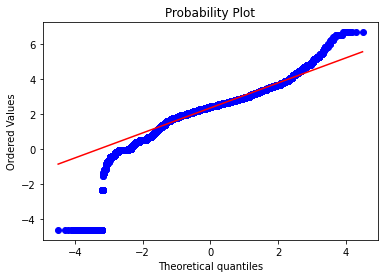

In [21]:
#analyze distribution and probability plots
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

prob = stats.probplot((train_set['price']), plot=plt)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


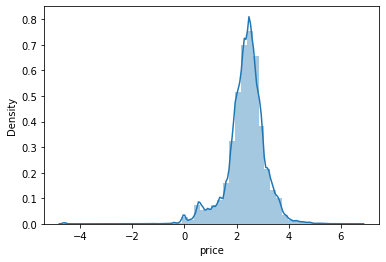

In [ ]:
sns.distplot(train_set['price'])

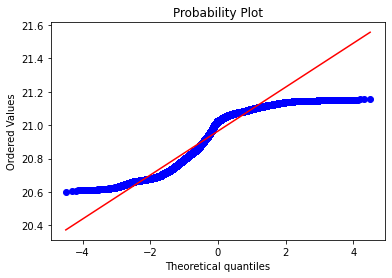

In [ ]:
prob = stats.probplot((train_set['unixReviewTime']), plot=plt)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


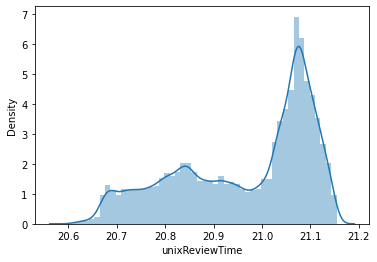

In [ ]:
sns.distplot((train_set['unixReviewTime']))

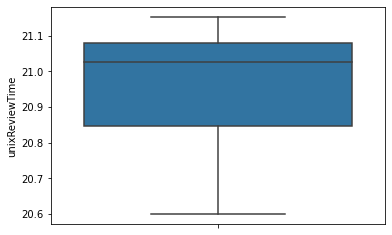

In [ ]:
sns.boxplot(y = train_set['unixReviewTime'])

In [ ]:
train_set.corr()

,overall,price,reviewYear,unixReviewTime,reviewHash,Classical,Dance & Electronic,Jazz,Pop
overall,1.000000,0.038009,0.153167,0.148225,0.004677,0.036568,0.001006,0.045631,0.017476
price,0.038009,1.000000,0.119610,0.119640,-0.002037,0.083865,-0.024889,0.039495,-0.008746
reviewYear,0.153167,0.119610,1.000000,0.996909,-0.002055,0.029953,-0.074997,0.070169,0.212449
unixReviewTime,0.148225,0.119640,0.996909,1.000000,-0.001903,0.031867,-0.076891,0.069297,0.211495
reviewHash,0.004677,-0.002037,-0.002055,-0.001903,1.000000,-0.000096,-0.000486,0.001597,-0.001168
Classical,0.036568,0.083865,0.029953,0.031867,-0.000096,1.000000,-0.083394,-0.106902,-0.297996
Dance & Electronic,0.001006,-0.024889,-0.074997,-0.076891,-0.000486,-0.083394,1.000000,-0.085649,-0.238751
Jazz,0.045631,0.039495,0.070169,0.069297,0.001597,-0.106902,-0.085649,1.000000,-0.306052
Pop,0.017476,-0.008746,0.212449,0.211495,-0.001168,-0.297996,-0.238751,-0.306052,1.000000


In [15]:
#clean the text data

import html 
#remove html characters
train_set['summary'] = train_set['summary'].fillna('').apply(html.unescape)
train_set['reviewText'] = train_set['reviewText'].fillna('').apply(html.unescape)

In [16]:
import re as re

def removeHtml(row):
    #remove html tags
    cleaned = re.sub('<.*?>','',row)
    #remove \n characters
    cleaned = re.sub('\n', '', cleaned)
    return cleaned

train_set['reviewText'] = train_set['reviewText'].apply(lambda a : removeHtml(a))

In [ ]:
#check the cleaned text data
with pd.option_context('display.max_colwidth', None):
  display(train_set.reviewText.head(25))

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     So is Katy Perry's new album "Teenage Dream" contrived, derived and unoriginal?  The answer to all three would be a resounding yes! So why on earth in spite of this fact is her new album so unbelievably great????  Well, the answer may be complicated if not impossible to fully answer.  The simple brilliance of Katy Perry would be simplicity and self awareness....thus t

In [ ]:
#These extra features did not improve the model

#train_set['summary_cnt'] = train_set['summary'].str.len()
#train_set['review_cnt'] = train_set['reviewText'].str.len()
#train_set['summary_words'] = train_set['summary'].str.split().str.len()
#train_set['review_words'] = train_set['reviewText'].str.split().str.len()
#train_set['summary_chr_per_wrd'] = train_set['summary_cnt']/train_set['summary_words']
#train_set['review_chr_per_wrd'] = train_set['review_cnt']/train_set['review_words']

#train_set = train_set.fillna(0)

#train_set['summary_num'] = train_set['summary'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

#train_set['review_num'] = train_set['reviewText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

#train_set.info()

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

stopWords = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#seperate each word (separated by spaces) and get the total number of words as well as top 50 words
reviews = train_set.reviewText.str.cat(sep=' ')
words = word_tokenize(reviews)
dictionary = set(words)
print(len(dictionary))
frequency = nltk.FreqDist(words)
sorted(frequency,key=frequency.__getitem__, reverse=True)[0:50]

468416


[',',
 '.',
 'the',
 'and',
 'of',
 'a',
 'to',
 'is',
 'I',
 "''",
 '``',
 "'s",
 'this',
 'it',
 'in',
 'that',
 'with',
 'on',
 'album',
 'The',
 'for',
 'as',
 'you',
 'are',
 'but',
 ')',
 '!',
 '(',
 'was',
 "n't",
 'have',
 'not',
 'like',
 'one',
 'music',
 'from',
 'songs',
 'song',
 'be',
 'all',
 'has',
 'This',
 'by',
 'more',
 'It',
 'his',
 'great',
 'my',
 'an',
 'they']

In [ ]:
summaries = train_set.summary.str.cat(sep=' ')
words = word_tokenize(summaries)
dictionary = set(words)
print(len(dictionary))
frequency = nltk.FreqDist(words)
sorted(frequency,key=frequency.__getitem__, reverse=True)[0:50]

55717


['!',
 'Stars',
 'Five',
 'the',
 '.',
 ',',
 '...',
 'of',
 'a',
 'A',
 'and',
 "'s",
 'The',
 'I',
 'to',
 'is',
 'Great',
 'album',
 'it',
 'this',
 'for',
 'great',
 '?',
 'but',
 'CD',
 'good',
 'best',
 "''",
 'in',
 '``',
 'music',
 'Good',
 'Four',
 'This',
 'you',
 'not',
 "n't",
 'with',
 '-',
 'from',
 'on',
 'Album',
 'Not',
 'Best',
 'One',
 'It',
 'as',
 'one',
 'like',
 'that']

In [ ]:
#get the counts of each word
count = train_set['reviewText'].str.split(expand=True).stack().value_counts()
print (count)

In [ ]:
count = train_set['summary'].str.split(expand=True).stack().value_counts()
print (count)

In [ ]:
#Removing punctuation, stopwords and stemming words did not help improve the model

#train_set['summary'] = train_set['summary'].str.replace('[^\w\s]','') 
#train_set['summary'] = train_set['summary'].apply(lambda a: " ".join(a for a in a.split() if a not in stopWords))
#train_set['summary'] = train_set['summary'].apply(lambda a: " ".join(a.lower() for a in a.split()))

#from nltk.stem import PorterStemmer
#stemmer = PorterStemmer()
#train_set['summary'] = train_set['summary'].apply(lambda a: " ".join([stemmer.stem(word) for word in a.split()]))

In [ ]:
#train_set['reviewText'] = train_set['reviewText'].str.replace('[^\w\s]','') 
#train_set['reviewText'] = train_set['reviewText'].apply(lambda a: " ".join(a for a in a.split() if a not in stop))
#train_set['reviewText'] = train_set['reviewText'].apply(lambda a: " ".join(a.lower() for a in a.split()))

#from nltk.stem import PorterStemmer
#stemmer = PorterStemmer()
#train_set['reviewText'] = train_set['reviewText'].apply(lambda a: " ".join([stemmer.stem(word) for word in a.split()]))

In [17]:
train_set.reviewText.describe()

count     200000
unique    184940
top        great
freq         662
Name: reviewText, dtype: object

In [18]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userID-itemID       200000 non-null  object 
 1   overall             200000 non-null  int64  
 2   price               200000 non-null  float64
 3   summary             200000 non-null  object 
 4   category            200000 non-null  object 
 5   reviewText          200000 non-null  object 
 6   reviewYear          200000 non-null  int64  
 7   unixReviewTime      200000 non-null  float64
 8   reviewHash          200000 non-null  int64  
 9   Classical           200000 non-null  uint8  
 10  Dance & Electronic  200000 non-null  uint8  
 11  Jazz                200000 non-null  uint8  
 12  Pop                 200000 non-null  uint8  
dtypes: float64(2), int64(3), object(4), uint8(4)
memory usage: 14.5+ MB


In [19]:
train_set.corr()

,overall,price,reviewYear,unixReviewTime,reviewHash,Classical,Dance & Electronic,Jazz,Pop
overall,1.000000,0.038009,0.153167,0.148225,0.004677,0.036568,0.001006,0.045631,0.017476
price,0.038009,1.000000,0.119610,0.119640,-0.002037,0.083865,-0.024889,0.039495,-0.008746
reviewYear,0.153167,0.119610,1.000000,0.996909,-0.002055,0.029953,-0.074997,0.070169,0.212449
unixReviewTime,0.148225,0.119640,0.996909,1.000000,-0.001903,0.031867,-0.076891,0.069297,0.211495
reviewHash,0.004677,-0.002037,-0.002055,-0.001903,1.000000,-0.000096,-0.000486,0.001597,-0.001168
Classical,0.036568,0.083865,0.029953,0.031867,-0.000096,1.000000,-0.083394,-0.106902,-0.297996
Dance & Electronic,0.001006,-0.024889,-0.074997,-0.076891,-0.000486,-0.083394,1.000000,-0.085649,-0.238751
Jazz,0.045631,0.039495,0.070169,0.069297,0.001597,-0.106902,-0.085649,1.000000,-0.306052
Pop,0.017476,-0.008746,0.212449,0.211495,-0.001168,-0.297996,-0.238751,-0.306052,1.000000


In [ ]:
#Did not use these columns for final model, scaled the values when used

#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()

In [ ]:
#train_set['summary_cnt'] = sc.fit_transform(train_set[['summary_cnt']])
#train_set['review_cnt'] = sc.fit_transform(train_set[['review_cnt']])
#train_set['summary_words'] = sc.fit_transform(train_set[['summary_words']])
#train_set['review_words'] = sc.fit_transform(train_set[['review_words']])
#train_set['summary_chr_per_wrd'] = sc.fit_transform(train_set[['summary_chr_per_wrd']])
#train_set['review_chr_per_wrd'] = sc.fit_transform(train_set[['review_chr_per_wrd']])
#train_set['summary_num'] = sc.fit_transform(train_set[['summary_num']])
#train_set['review_num'] = sc.fit_transform(train_set[['review_num']])

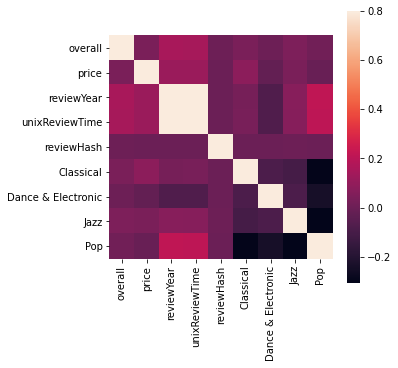

In [22]:
#correlation heat map for features 
plt.figure(figsize = (5, 5))
sns.heatmap(train_set.corr() ,vmax=.8, square=True)

In [23]:
#Splitting the features and label

#X = train_set[['price','summary', 'reviewText', 'reviewYear', 'unixReviewTime' ,'Classical','Dance & Electronic','Jazz','Pop', 'reviewHash', 'summary_cnt', 'review_cnt', 'summary_words', 'review_cnt', 'summary_words', 'review_words', 'summary_chr_per_wrd', 'review_chr_per_wrd', 'summary_num', 'review_num']]
X = train_set[['price','summary', 'reviewText', 'reviewYear', 'unixReviewTime' ,'Classical','Dance & Electronic','Jazz','Pop']]

y = train_set[['overall']]

In [24]:
#train test split of 20% test 80% train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [25]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Obtain the text data: get_text_data
get_reviewtext_data = FunctionTransformer(lambda x: x['reviewText'], validate=False)

get_summary_data = FunctionTransformer(lambda x: x['summary'], validate=False)

# Obtain the numeric data: get_numeric_data
#get_numeric_data = FunctionTransformer(lambda x: x[['price', 'reviewYear', 'unixReviewTime', 'Classical','Dance & Electronic','Jazz','Pop', 'reviewHash', 'summary_cnt', 'review_cnt', 'summary_words', 'review_cnt', 'summary_words', 'review_words', 'summary_chr_per_wrd', 'review_chr_per_wrd', 'summary_num', 'review_num']], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[['price', 'reviewYear', 'unixReviewTime', 'Classical','Dance & Electronic','Jazz','Pop']], validate=False)


In [26]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

In [27]:
#union of numeric and text features for our pipeline with TfidfVectorizer for text features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data)                                     
                ])),
                ('text_features', Pipeline([
                    ('selector', get_reviewtext_data),
                    ('vectorizer', TfidfVectorizer(ngram_range=(1,2)))
                ])),
                ('text_features2', Pipeline([
                    ('selector', get_summary_data),
                    ('vectorizer', TfidfVectorizer(ngram_range=(1,2)))
                ]))
             ]
        )

In [28]:
#the pipeline
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', Ridge())
    ])

In [ ]:
#Ridge parameters

#l1_space = np.linspace(0, 1, 5)
#parameters = {'clf__l1_ratio': l1_space}

In [ ]:
#from sklearn.model_selection import GridSearchCV

#param= { 'clf__alpha' : [0.01, 0.1, 1,10] }

#cv = GridSearchCV(pl, param_grid = param)

#cv.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_features',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         FunctionTransformer(accept_sparse=False,
                                                                                                             check_inverse=True,
                                                                                                             func=<function <lambda> at 0x7fd23b7abea0>,
                                                                                                      

In [ ]:
#print("Tuned Ridge Parameters: {}".format(cv.best_params_)) 

Tuned Ridge Parameters: {'clf__alpha': 1}


In [ ]:
#print("Best score is {}".format(cv.best_score_))

Best score is 0.41482500629785707


In [ ]:
#cv = cross_val_score(pl, X, y, cv = 10)

In [ ]:
#cv.mean()

0.5768451688698882

In [ ]:
#y_train_regressor = y_train.values.ravel() 

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 102941 to 183457
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               160000 non-null  float64
 1   summary             160000 non-null  object 
 2   reviewText          160000 non-null  object 
 3   reviewYear          160000 non-null  int64  
 4   unixReviewTime      160000 non-null  float64
 5   Classical           160000 non-null  uint8  
 6   Dance & Electronic  160000 non-null  uint8  
 7   Jazz                160000 non-null  uint8  
 8   Pop                 160000 non-null  uint8  
dtypes: float64(2), int64(1), object(2), uint8(4)
memory usage: 7.9+ MB


In [30]:
#fit the pipeline
pl.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7ff6c0537950>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                       

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
#make predictions on test part of train data
y_pred =pl.predict(X_test)

In [33]:
#get the mean squared error
print(mean_squared_error(y_test,y_pred,squared =True))

0.42813826675472666


In [ ]:
#MODEL COMPARISON (with scaled price, unixreview)

#Ridge -> 0.4156409682496042
#0.42687672511032304



In [ ]:
#Try Ridge with reviewHash

0.427977313762514

In [ ]:
#MODEL COMPARISON (with scaled price, reviewhash, unixreview, text extra num features)

#Ridge -> 0.42845148074285155

#Logistic Regression -> 1.35775

#Lasso -> 0.9980335759765625

#Random Forest Regressor -> 0.9068001833403765

#SVM SVR -> can't run

#Linear Regression -> 


In [ ]:
#ridge with no extra text features and no extra processing -> 0.42400667434199074

#0.4269779562103067????^^^^



#ridge with no extra text features or processing, price and unixreviewtime scaled -> 0.42620553419989127

#ridge with no extra text features or processing, price, reviewHash and unixreviewtime scaled -> 0.41681973923557


#ridge with extra text features but no extra processing -> 0.42185061675527025

#0.4266482840462476????^^^^

#0.4269494743639818????^^^^

#0.4212203777021481

#linear regression with extra text features but no extra processing -> 0.46968237919400835


#ridge with extra text features + summary processing 1 -> 0.4273054323492646

#ridge with extra text features + stemmed reviewtext -> 0.4270899405668326


In [34]:
#read test set and apply same data processing
test_set = pd.read_json('test.json', lines = True)

In [35]:
test_set['reviewYear'] = test_set['reviewTime'].str.split('\,').str[-1].str.strip()

test_set['reviewYear'] = test_set['reviewYear'].apply(int)

In [36]:
test_set =  test_set[['itemID', 'price', 'reviewerID', 'summary','category','reviewYear', 'unixReviewTime' ,'reviewText']]

In [37]:
def join(record):
    return record['reviewerID']+"-"+record['itemID']

In [38]:
test_set['userID-itemID'] = test_set.apply(join,axis =1)

In [39]:
test_set = test_set[['userID-itemID', 'price','summary','category','reviewYear', 'unixReviewTime', 'reviewText']]

In [40]:
test_set.price = test_set.price.str.strip('$')


In [41]:
test_set['price'] = pd.to_numeric(test_set['price'], errors='coerce')

In [42]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   userID-itemID   10000 non-null  object 
 1   price           9857 non-null   float64
 2   summary         9998 non-null   object 
 3   category        10000 non-null  object 
 4   reviewYear      10000 non-null  int64  
 5   unixReviewTime  10000 non-null  int64  
 6   reviewText      9999 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 547.0+ KB


In [43]:
#test_set['price'] = pd.to_numeric(test_set['price'], errors='coerce')
test_set.info()
df2 = pd.get_dummies(test_set['category'],drop_first =True)
test_set = pd.concat([test_set, df2],axis = 'columns')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   userID-itemID   10000 non-null  object 
 1   price           9857 non-null   float64
 2   summary         9998 non-null   object 
 3   category        10000 non-null  object 
 4   reviewYear      10000 non-null  int64  
 5   unixReviewTime  10000 non-null  int64  
 6   reviewText      9999 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 547.0+ KB


In [44]:
test_set.fillna(method='ffill',inplace =True)

In [45]:
test_set['price'] = np.log(test_set[['price']])
test_set['unixReviewTime'] = np.log(test_set[['unixReviewTime']])

In [46]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userID-itemID       10000 non-null  object 
 1   price               10000 non-null  float64
 2   summary             10000 non-null  object 
 3   category            10000 non-null  object 
 4   reviewYear          10000 non-null  int64  
 5   unixReviewTime      10000 non-null  float64
 6   reviewText          10000 non-null  object 
 7   Classical           10000 non-null  uint8  
 8   Dance & Electronic  10000 non-null  uint8  
 9   Jazz                10000 non-null  uint8  
 10  Pop                 10000 non-null  uint8  
dtypes: float64(2), int64(1), object(4), uint8(4)
memory usage: 586.1+ KB


In [47]:
import html 

test_set['summary'] = test_set['summary'].fillna('').apply(html.unescape)
test_set['reviewText'] = test_set['reviewText'].fillna('').apply(html.unescape)

In [48]:
import re as re
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    result = re.sub('\n', '', result)
    return result
test_set['reviewText']=test_set['reviewText'].apply(lambda cw : remove_tags(cw))

In [49]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userID-itemID       10000 non-null  object 
 1   price               10000 non-null  float64
 2   summary             10000 non-null  object 
 3   category            10000 non-null  object 
 4   reviewYear          10000 non-null  int64  
 5   unixReviewTime      10000 non-null  float64
 6   reviewText          10000 non-null  object 
 7   Classical           10000 non-null  uint8  
 8   Dance & Electronic  10000 non-null  uint8  
 9   Jazz                10000 non-null  uint8  
 10  Pop                 10000 non-null  uint8  
dtypes: float64(2), int64(1), object(4), uint8(4)
memory usage: 586.1+ KB


In [50]:
X_test_set = test_set[['price','summary', 'reviewText', 'reviewYear', 'unixReviewTime', 'Classical','Dance & Electronic','Jazz','Pop']]

In [51]:
X_test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               10000 non-null  float64
 1   summary             10000 non-null  object 
 2   reviewText          10000 non-null  object 
 3   reviewYear          10000 non-null  int64  
 4   unixReviewTime      10000 non-null  float64
 5   Classical           10000 non-null  uint8  
 6   Dance & Electronic  10000 non-null  uint8  
 7   Jazz                10000 non-null  uint8  
 8   Pop                 10000 non-null  uint8  
dtypes: float64(2), int64(1), object(2), uint8(4)
memory usage: 429.8+ KB


In [ ]:
#predict on unseen test data
test_pred = pl.predict(X_test_set)

In [ ]:
test_pred

In [ ]:
#reset index in test data 
test_set.reset_index(inplace = True)

In [ ]:
#get the list of userid-itemid
Final = test_set[['userID-itemID']]

In [ ]:
#make a column of the predictions
Final['prediction'] = test_pred

In [ ]:
#set userid-itemid as index
Final.set_index('userID-itemID')

In [ ]:
#output rating prediction pairs as csv
Final.to_csv('rating_predictions.csv')